# 8.1 Engine lifetime with RNNs

In this exercise, you will develop a Recurrent Neural Network capable of estimating the lifetime of engines. Your final submission should include a link to your google collab notebook, and a pdf adressing the questions asked in the task. You can use this template to get started: https://colab.research.google.com/drive/1HeCd0EIGTEbAAVNgyWeMKMgCejKcA031#scrollTo=A_dA-aOjvbza

The paper that can help you with the exercises can be found here:\
Wang, Y., Zhao, Y. & Addepalli, S. Practical Options for Adopting Recurrent Neural Network and Its Variants on Remaining Useful Life Prediction. Chin. J. Mech. Eng. 34, 69 (2021). https://doi.org/10.1186/s10033-021-00588-x

## Experimental Scenario

The data sets consists of multiple multivariate time series. Each data set is further divided into training and test subsets. Each time series is from a different engine i.e., the data can be considered to be from a fleet of engines of the same type. Each engine starts with different degrees of initial wear and manufacturing variation which is unknown to the user. This wear and variation is considered normal, i.e., it is not considered a fault condition. There are three operational settings that have a substantial effect on engine performance. These settings are also included in the data. The data is contaminated with sensor noise.

The engine is operating normally at the start of each time series, and develops a fault at some point during the series. In the training set, the fault grows in magnitude until system failure. Therefore, the labels for the training data set have to be determined from the remaining time steps. In the test set, the time series ends some time prior to system failure. The objective of the exercise is to predict the number of remaining operational cycles before failure in the test set, i.e., the number of operational cycles after the last cycle that the engine will continue to operate. Also provided is a vector of true Remaining Useful Life (RUL) values for the test data.

The data are provided as a zip-compressed text file with 26 columns of numbers, separated by spaces. Each row is a snapshot of data taken during a single operational cycle, each column is a different variable. The columns correspond to:

1\.	unit number\
2\.	time, in cycles\
3\.	operational setting 1\
4\.	operational setting 2\
5\.	operational setting 3\
6\.	sensor measurement  1\
7\.	sensor measurement  2\
... \
26\.	sensor measurement  21

For this exercise we only consider the FD001 data set.

Data Set: FD001\
Train trjectories: 100\
Test trajectories: 100\
Conditions: ONE (Sea Level)\
Fault Modes: ONE (HPC Degradation)




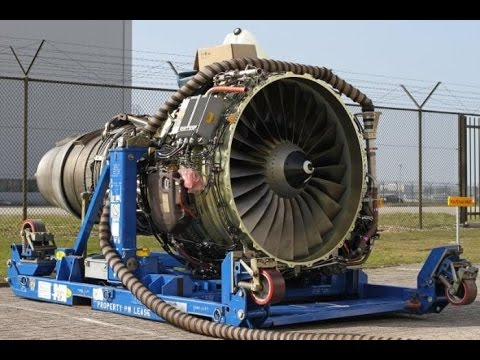



Y. Dwivedi, Predicting Engine Failure using C-MAPSS data, 2018 (https://yajasd.github.io/2018/06/04/Predicting-Engine-Failure/)

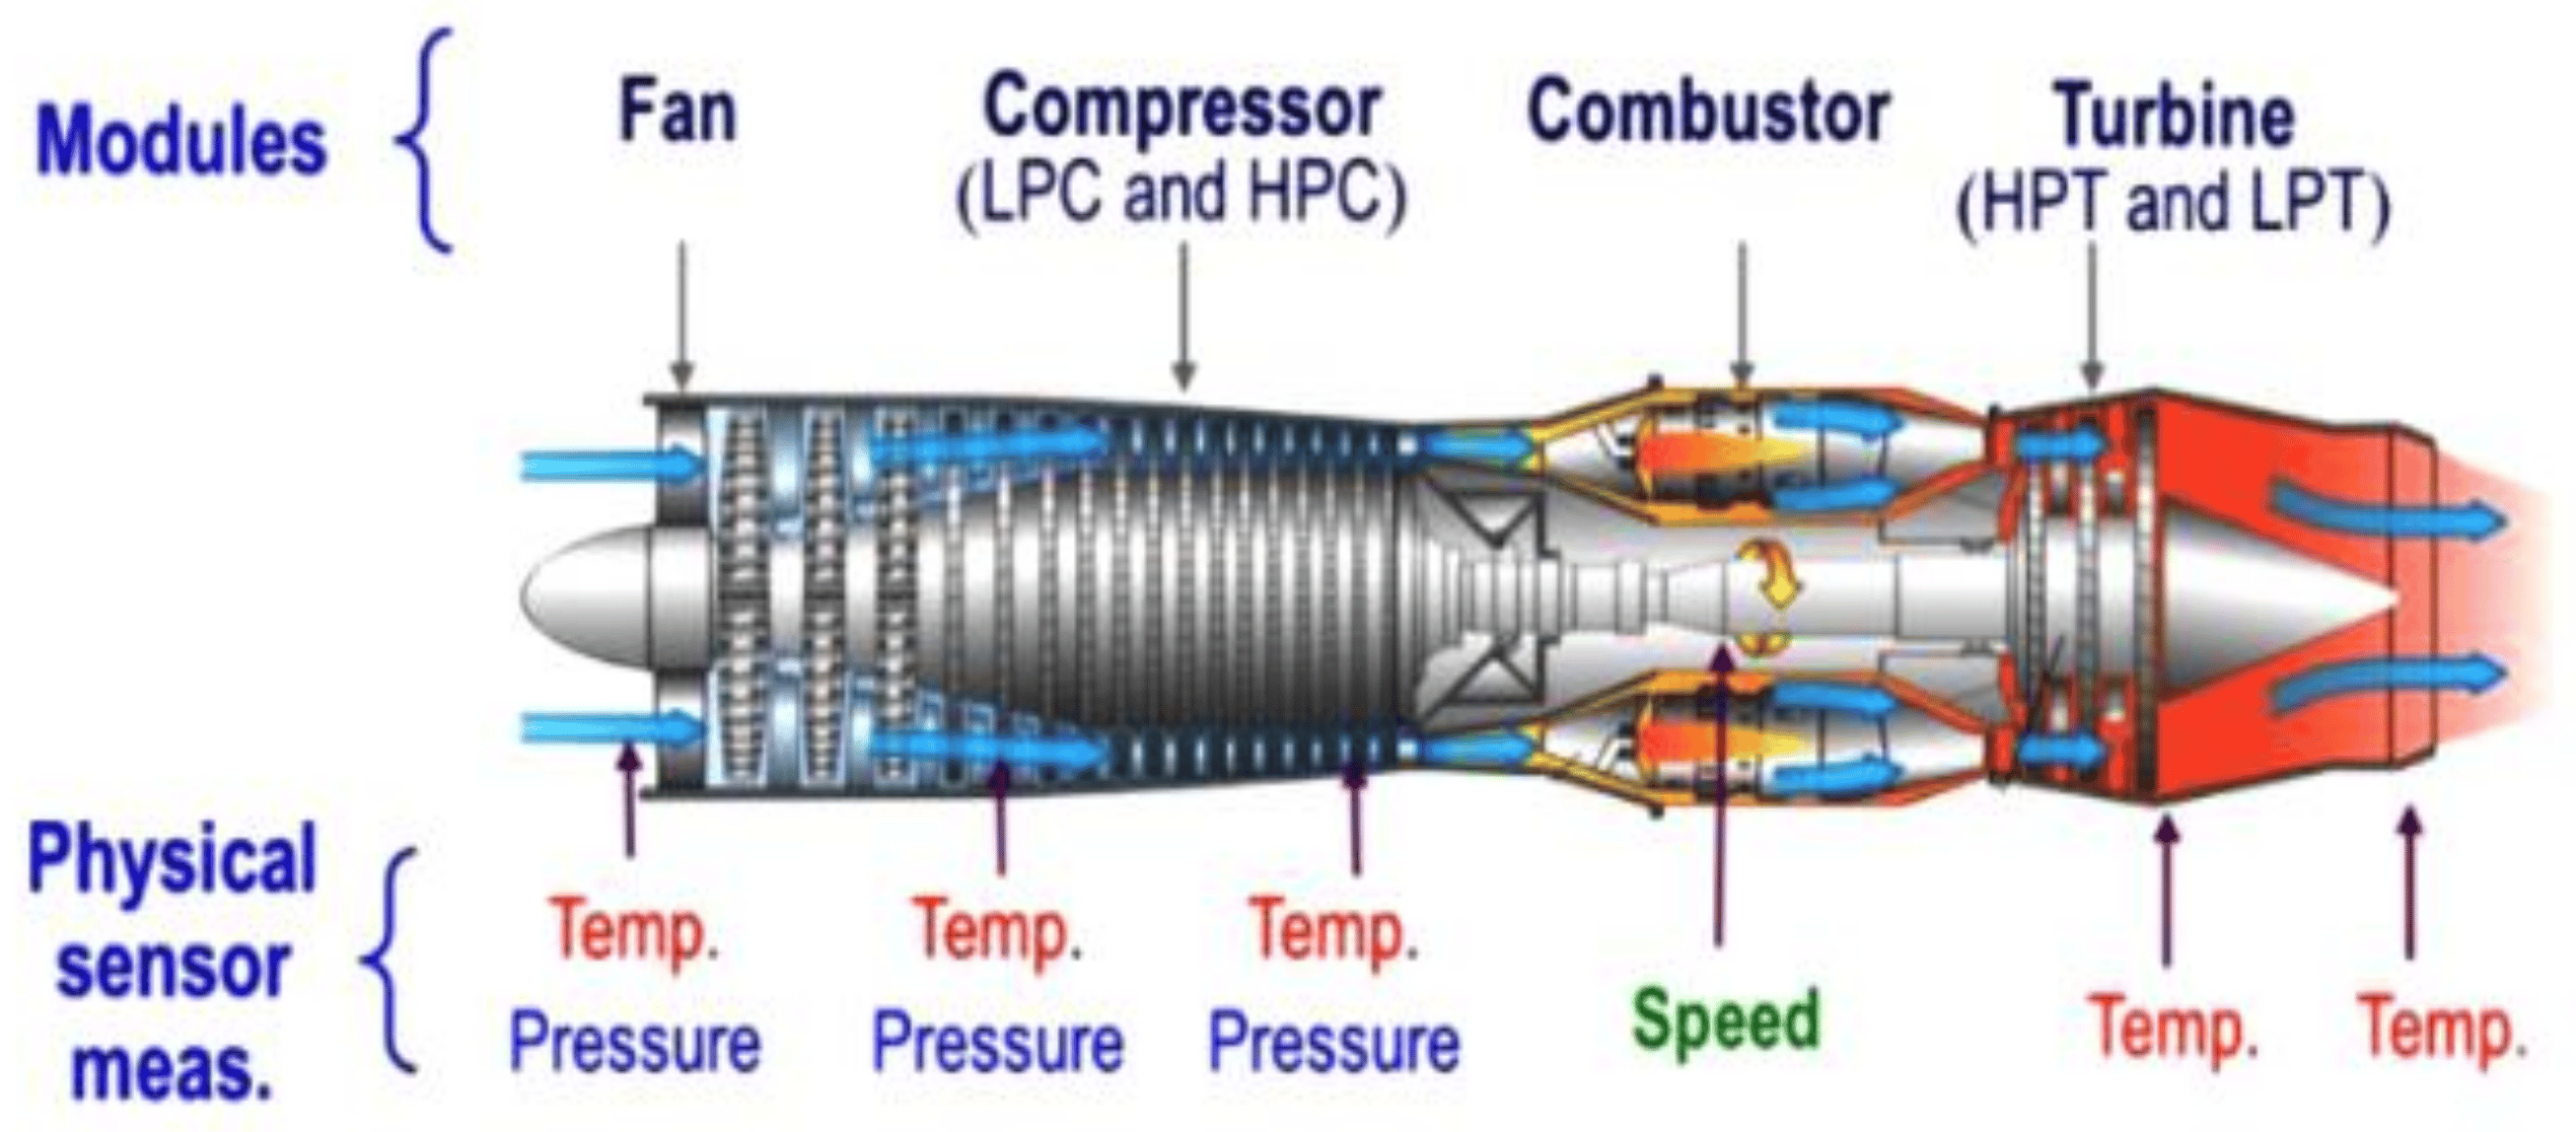


Muneer, A.; Taib, S.M.; Naseer, S.; Ali, R.F.; Aziz, I.A. Data-Driven Deep Learning-Based Attention Mechanism for Remaining Useful Life Prediction: Case Study Application to Turbofan Engine Analysis. Electronics 2021, 10, 2453. https://doi.org/10.3390/electronics10202453

## Exercises

The data structure of the input data is the most important thing when training a RNN. Make sure you understand the format of the input data.


1.   Normalize the input data. It can be useful to use helper functions instead of manually implementing the normaliztion. Here, you get to know the `sklearn` package. Please use the functions `sklearn.preprocessing.StandardScaler().fit()` and `sklearn.preprocessing.StandardScaler().transform()`. For additional help see the documentation (https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) and this tutorial (https://www.youtube.com/watch?v=ZddUwo4R5ug).

2.   Make several plots to understand the input data for all, and for a single unit. How do the plots change after the normalization? Also plot the labels for the training data.

3.   Explain in your notes what the for-loop in section 10 is doing and why it is important. Is there an optimal value for n_past? Try to find it. Hint: Consider the input dimensions for the test data set.

4.   Set up your RNN in section 13 using `keras.layers.LSTM()`. Think about what dimension the final dense layer should have.

5.   Set up the `model.fit` function in section 14 and train your RNN model. Test different callback options. What do you notice during training? Write down your reflections and what thoughts went into your final training strategy.

6.   Plot the training and validation loss against training epochs.

7.   Apply the trained model to both, the trainning data set, and the test data set.

8.   Make several plots to evaluate the trained model. Start with a plot where you compare the training data labels to the predictions your final model makes for the training data set. For the test data, plot the predictions and the true values for each unit. In a second figure, plot the residuals of your predictions as a histogram.

9.   Use the MSE function to break down the performance of your model to a single number.

10.   If you want to be 95% sure that the engine still has at least 20 cycles to go, at what network output should you recommend maintenance? (The histogram with the residuals can help you with your estimate.)



## 1) Importing relevant libraries

In [ ]:
# you don't have to touch this
import numpy as np
import matplotlib.pyplot as plt
import keras
import pandas as pd
import os
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

layers = keras.layers
models = keras.models

print(keras.__version__)

3.5.0


## 2) Downloading the Data

In [ ]:
#downloading the data set
# you don't have to touch this
if os.path.exists("application%2Fzip") == False:
  !wget https://data.nasa.gov/download/ff5v-kuh6/application%2Fzip
  !unzip application%2Fzip

--2024-12-05 16:55:51--  https://data.nasa.gov/download/ff5v-kuh6/application%2Fzip
Resolving data.nasa.gov (data.nasa.gov)... 128.102.186.77, 2001:4d0:6311:2c05:60b0:5ad8:1210:ea07
Connecting to data.nasa.gov (data.nasa.gov)|128.102.186.77|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://data.nasa.gov/api/views/ff5v-kuh6/files/680c0016-00ca-47a5-a4b9-e6c9437f8409?filename=CMAPSSData.zip [following]
--2024-12-05 16:55:52--  https://data.nasa.gov/api/views/ff5v-kuh6/files/680c0016-00ca-47a5-a4b9-e6c9437f8409?filename=CMAPSSData.zip
Reusing existing connection to data.nasa.gov:443.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/octet-stream]
Saving to: ‘application%2Fzip’

application%2Fzip       [      <=>           ]  11.85M  7.54MB/s    in 1.6s    

2024-12-05 16:55:54 (7.54 MB/s) - ‘application%2Fzip’ saved [12425978]

Archive:  application%2Fzip
  inflating: Damage Propagation Modeling.pdf  
  inflating: readme.t

## 3) Preparing the training data

In [ ]:
#training data set without labels
# you don't have to touch this

data_train = pd.read_csv('train_FD001.txt', delimiter=' ', header=None)
number_of_sensors = 21

name_list = ['unit', 'time', 'setting0', 'setting1', 'setting2']
for i in range(number_of_sensors):
  name_list.append('sensor'+str(i))

name_list.append('empty1')
name_list.append('empty2')
data_train.columns = name_list
data_train = data_train.drop(['empty1'], axis=1)
data_train = data_train.drop(['empty2'], axis=1)

print(data_train['time'])


0          1
1          2
2          3
3          4
4          5
        ... 
20626    196
20627    197
20628    198
20629    199
20630    200
Name: time, Length: 20631, dtype: int64


## 4) Plot the data for all units

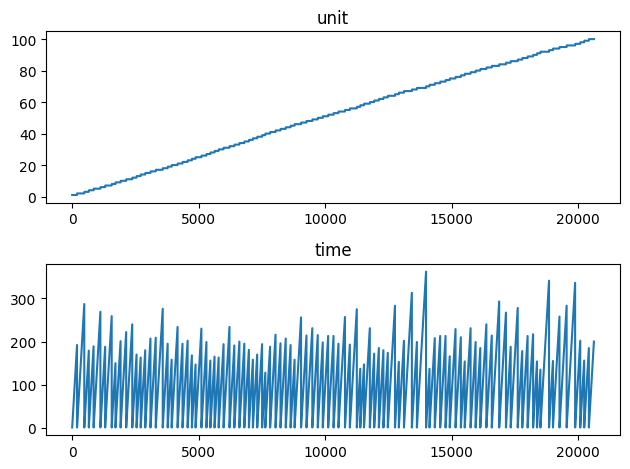

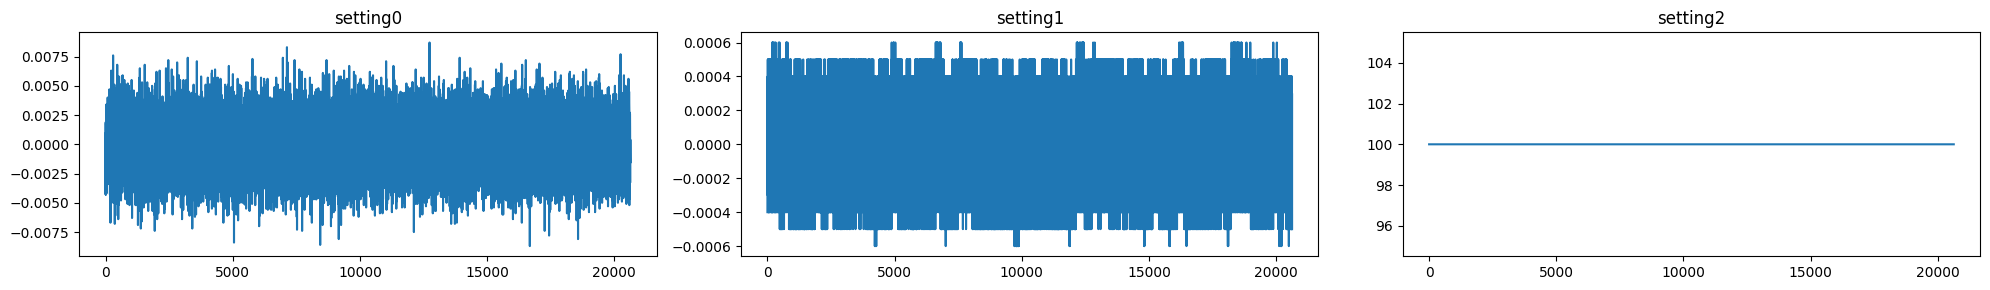

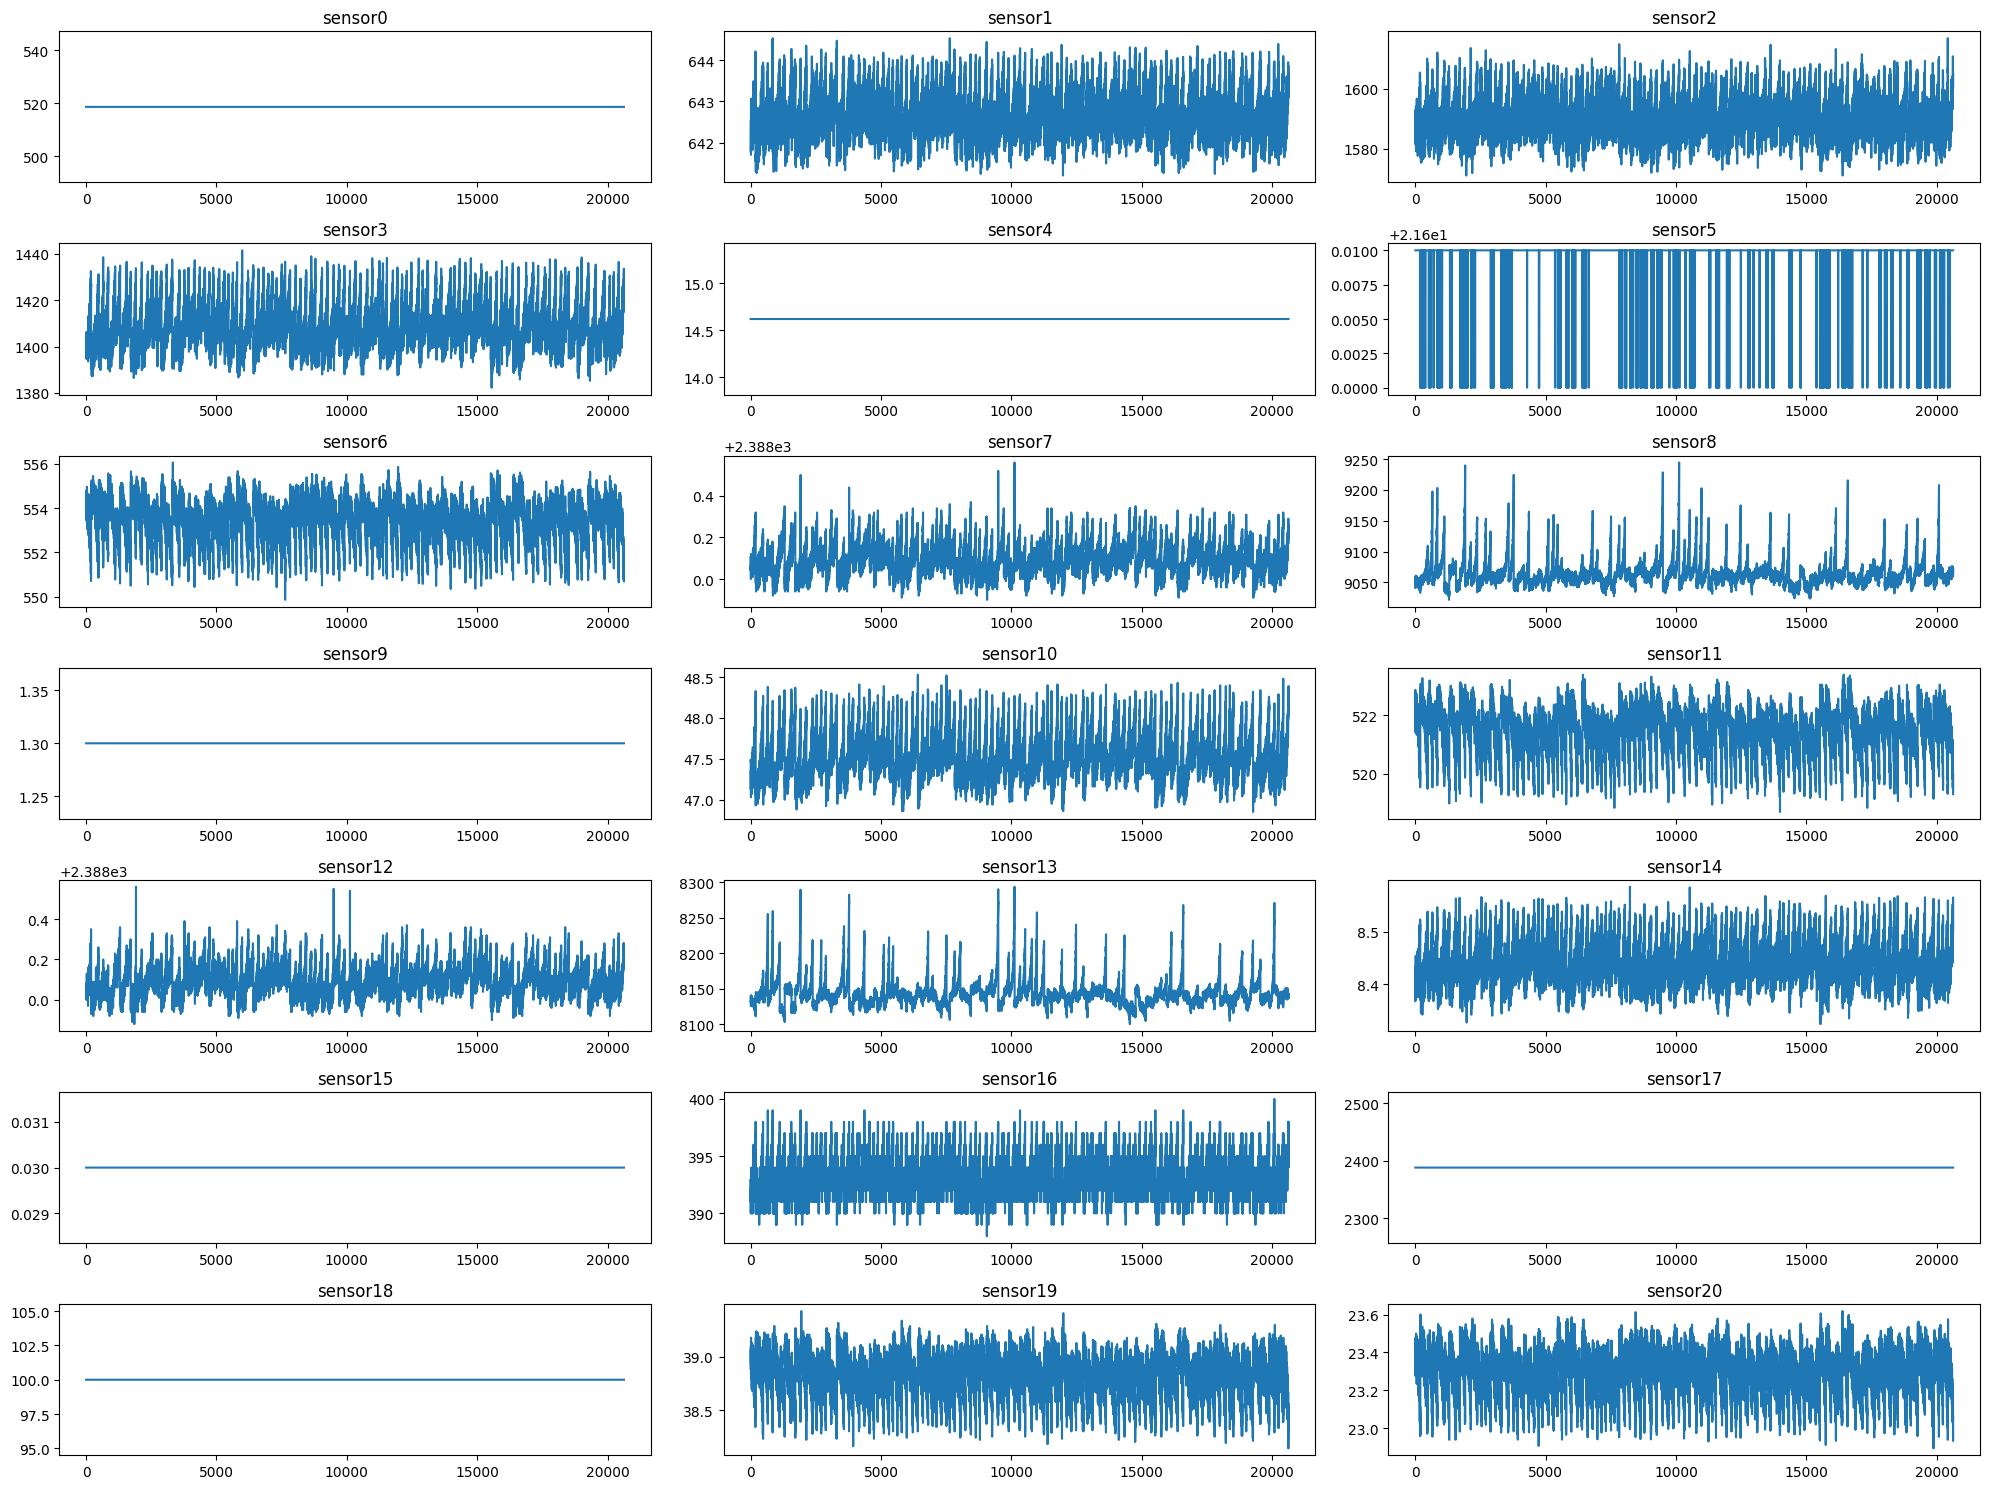

In [ ]:
#plot the input data for all units
fig, ax = plt.subplots(2, 1)
ax[0].plot(data_train['unit'])
ax[0].set_title('unit')
ax[1].plot(data_train['time'])
ax[1].set_title('time')
fig.tight_layout()
plt.show()
plt.close()

fig, ax = plt.subplots(1, 3, figsize=(20, 3))
ax[0].plot(data_train['setting0'])
ax[0].set_title('setting0')
ax[1].plot(data_train['setting1'])
ax[1].set_title('setting1')
ax[2].plot(data_train['setting2'])
ax[2].set_title('setting2')
fig.tight_layout()
plt.show()
plt.close()

sensor_columns = data_train.keys()[5:]

fig, ax = plt.subplots(7, 3, figsize=(20, 15))
for i, sensor in enumerate(sensor_columns):
  ax[i//3, i%3].plot(data_train[sensor])
  ax[i//3, i%3].set_title(sensor)
fig.tight_layout()
plt.show()
plt.close()


## 5) Plot the data for a single unit

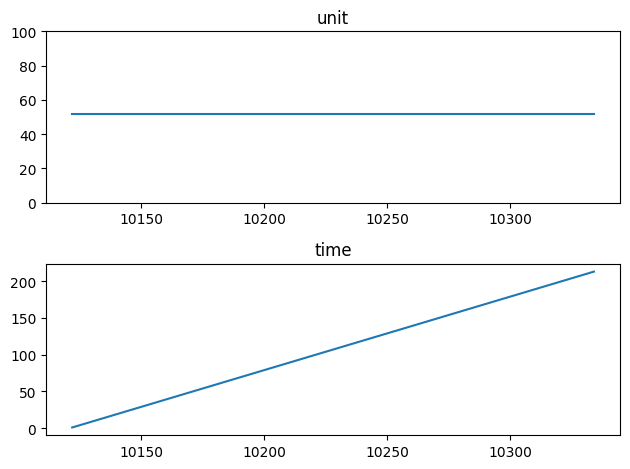

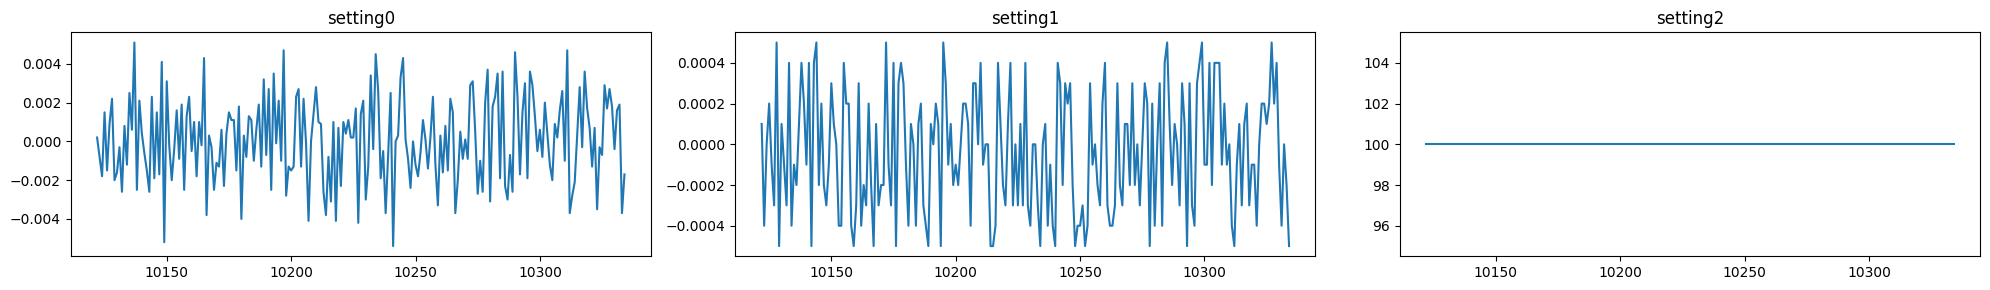

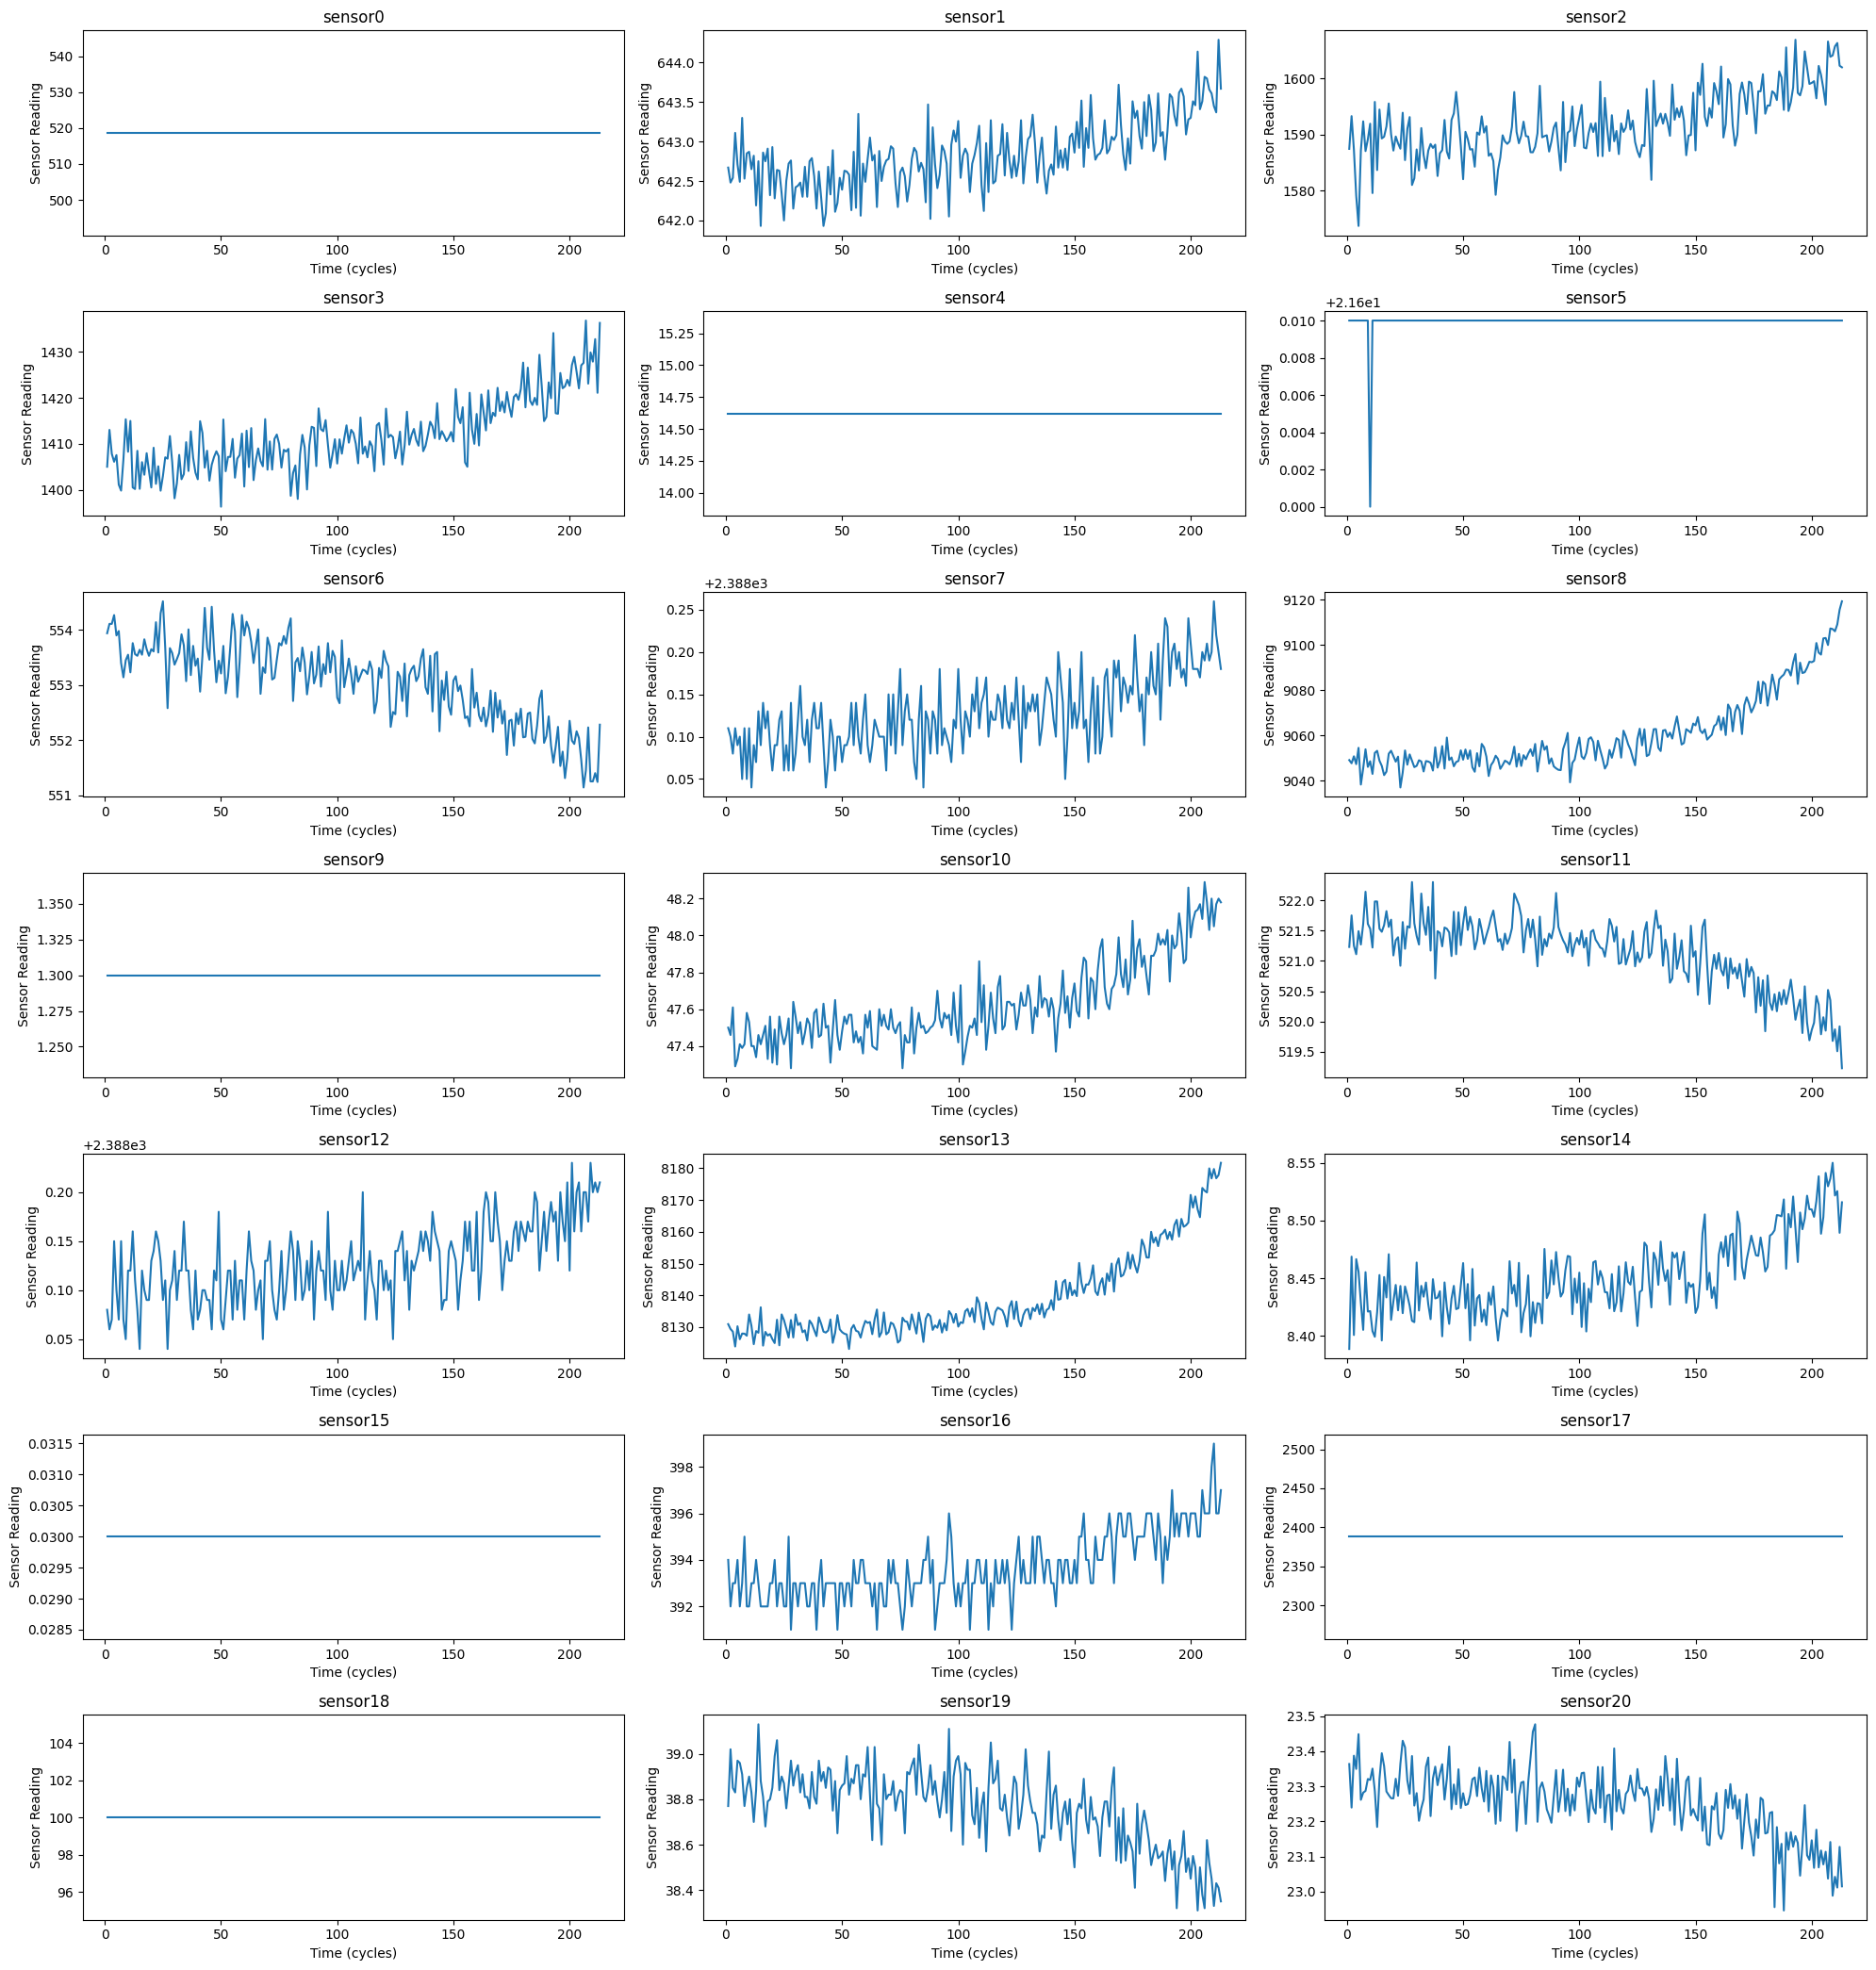

In [ ]:
#plot the input data for a single unit

np.random.seed(42)
unit_num = np.random.randint(1, 101)
unit_data = data_train[data_train['unit'] == unit_num] # Pick a random unit

# Plot unit and time
fig, ax = plt.subplots(2, 1)
ax[0].plot(unit_data['unit'])
ax[0].set_title('unit')
ax[0].set_ylim(0, 100)
ax[1].plot(unit_data['time'])
ax[1].set_title('time')
fig.tight_layout()
plt.show()
plt.close()

# Plot settings over time
fig, ax = plt.subplots(1, 3, figsize=(20, 3))
ax[0].plot(unit_data['setting0'])
ax[0].set_title('setting0')
ax[1].plot(unit_data['setting1'])
ax[1].set_title('setting1')
ax[2].plot(unit_data['setting2'])
ax[2].set_title('setting2')
fig.tight_layout()
plt.show()
plt.close()

# Plot sensor data
fig, ax = plt.subplots(7, 3, figsize=(20, 21))
sensor_columns = data_train.keys()[5:]

for i, sensor in enumerate(sensor_columns):
    ax[i // 3, i % 3].plot(unit_data['time'], unit_data[sensor])
    ax[i // 3, i % 3].set_title(sensor)
    ax[i // 3, i % 3].set_xlabel("Time (cycles)")
    ax[i // 3, i % 3].set_ylabel("Sensor Reading")

fig.tight_layout()
plt.show()
plt.close()


## 6) Drop irrelevant columns and normalize the training data

In the above plots I found that several columns contain useless data in the form of constant information. However, sensor 5 sometimes shows dips that can be useful. Therefore I will remove all except sensor 5.

*   Setting 2
*   Sensor 0
*   Sensor 4
*   Sensor 5 (sometimes has dips in the data which may be useful)
*   Sensor 9
*   Sensor 15
*   Sensor 17
*   Sensor 18




In [ ]:
#training data set without labels

data_train = pd.read_csv('train_FD001.txt', delimiter=' ', header=None)
number_of_sensors = 21

name_list = ['unit', 'time', 'setting0', 'setting1', 'setting2']
for i in range(number_of_sensors):
  name_list.append('sensor'+str(i))

name_list.append('empty1')
name_list.append('empty2')
data_train.columns = name_list
data_train = data_train.drop(['empty1'], axis=1)
data_train = data_train.drop(['empty2'], axis=1)

#choose which columns of data you want to keep and which you want to drop.
#Training with everything works but might not be the best choice.
data_train = data_train.drop(['setting2'], axis=1)
data_train = data_train.drop(['sensor0'], axis=1)
data_train = data_train.drop(['sensor4'], axis=1)
data_train = data_train.drop(['sensor9'], axis=1)
data_train = data_train.drop(['sensor15'], axis=1)
data_train = data_train.drop(['sensor17'], axis=1)
data_train = data_train.drop(['sensor18'], axis=1)

#normalization of the training data
scaler = StandardScaler()
scaler.fit(data_train)
data_train_scaled = scaler.transform(data_train)

columns = data_train_scaled.shape[1]

print(data_train_scaled.shape)

(20631, 19)


## 7) Plot the normalized the training data for all units and a single unit

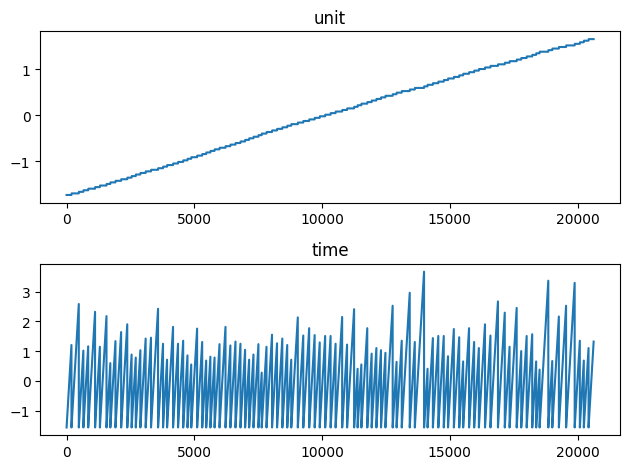

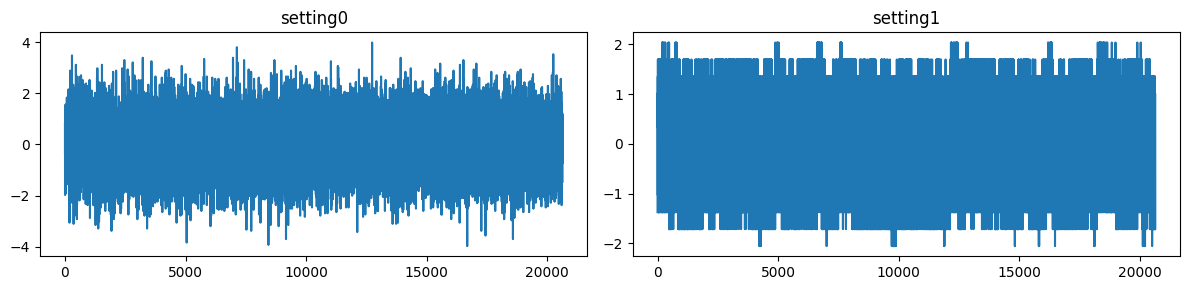

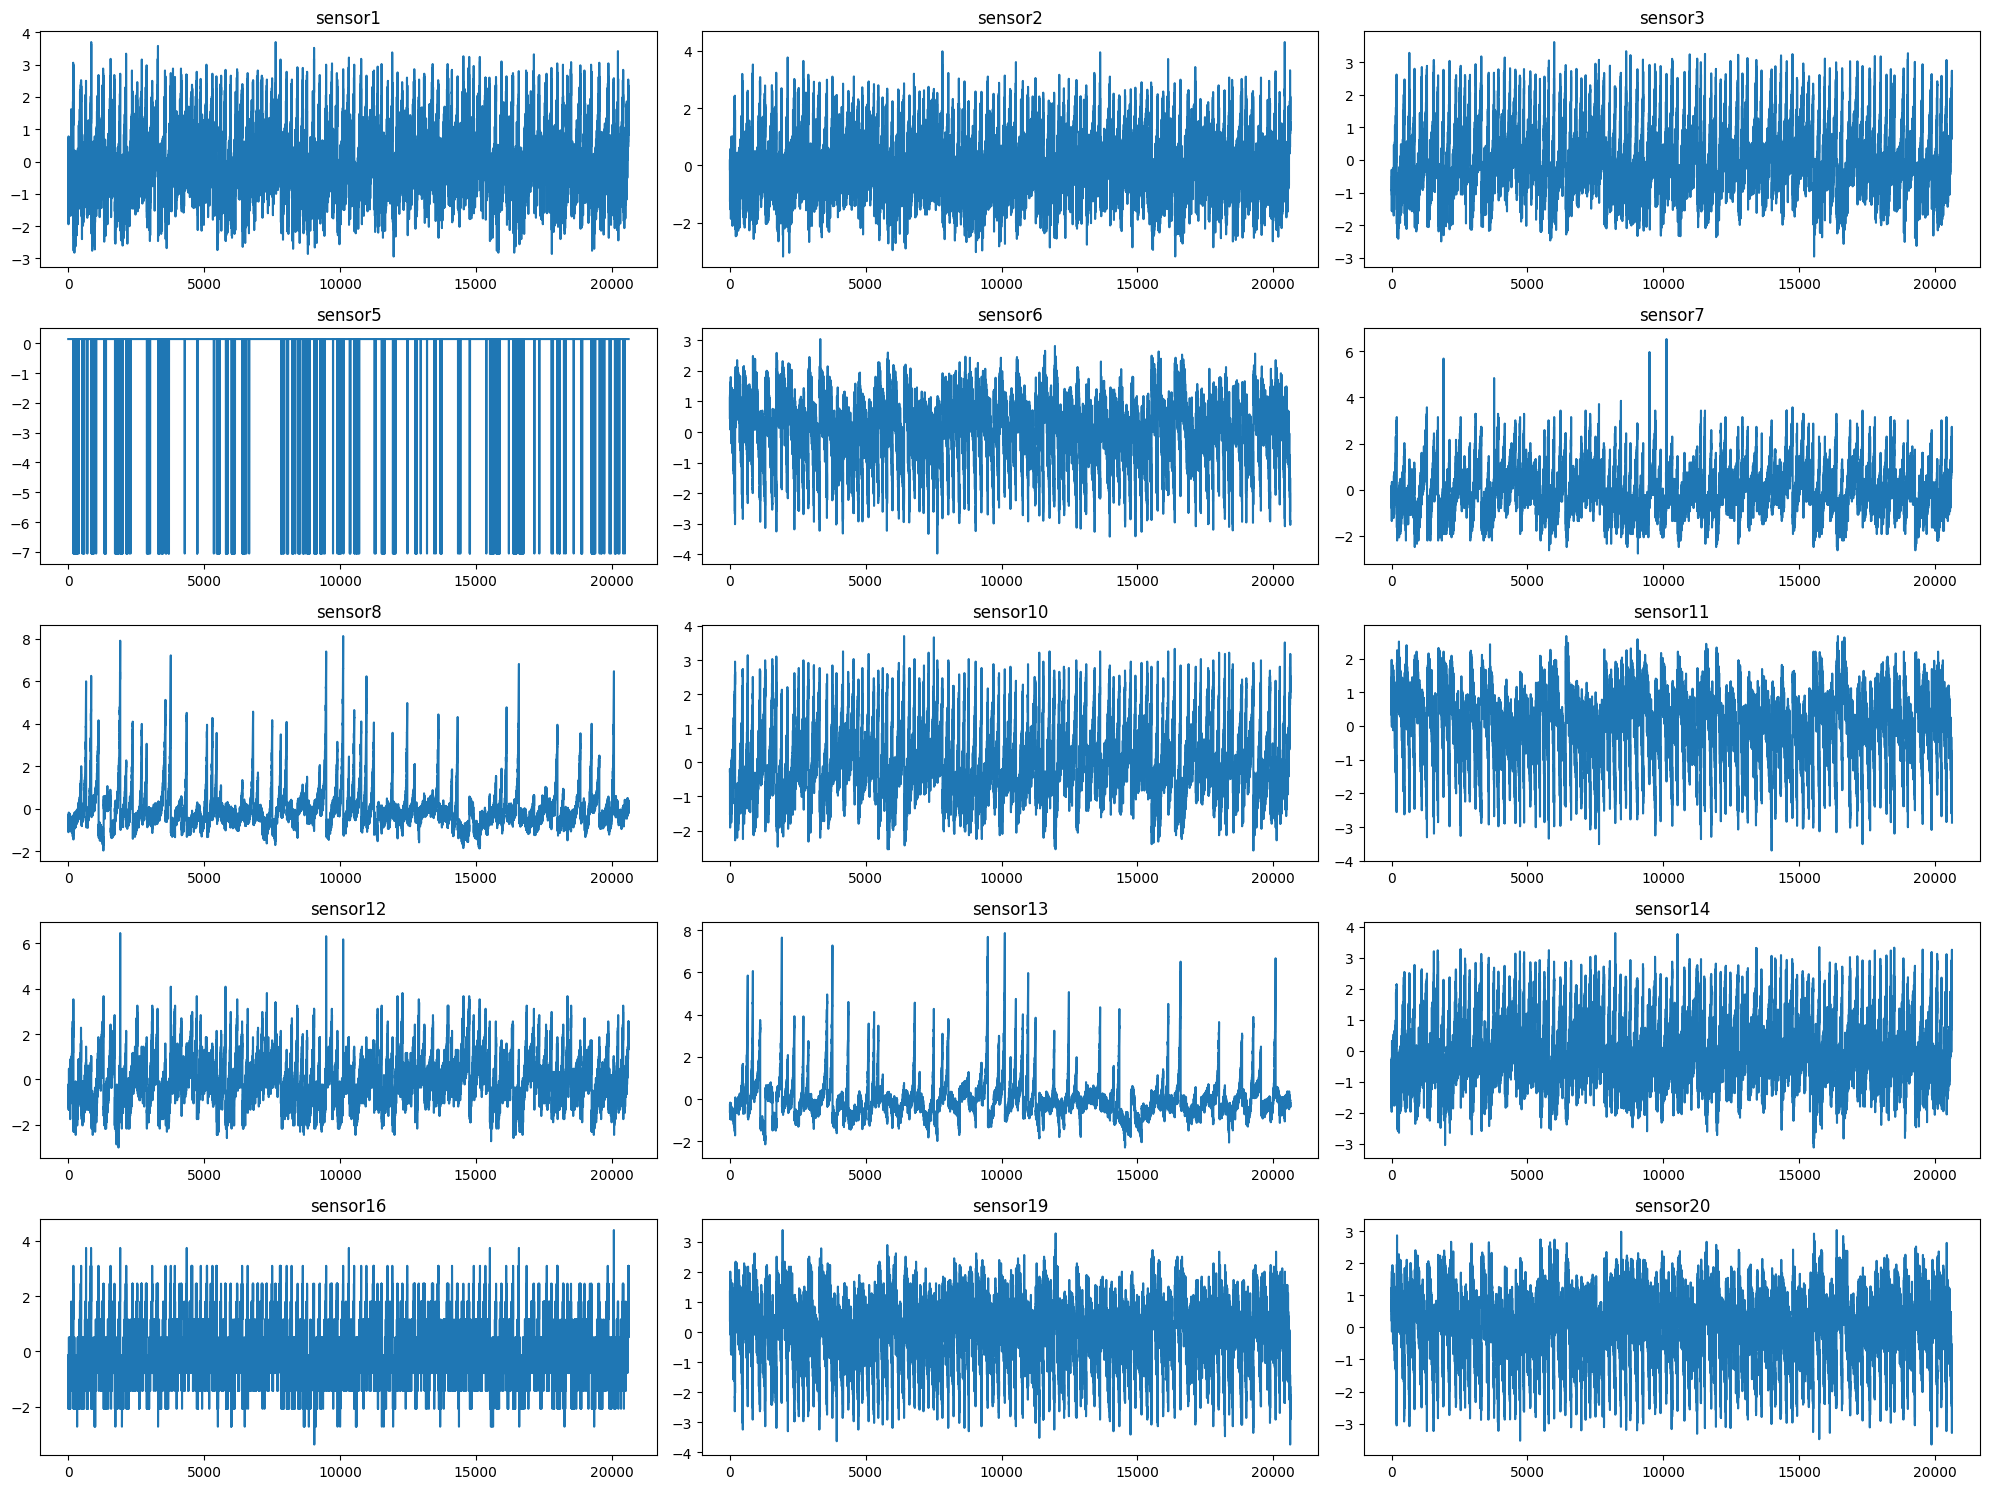

In [ ]:
#plot the normalized input data for all units
fig, ax = plt.subplots(2, 1)
ax[0].plot(data_train_scaled[:, 0])
ax[0].set_title('unit')
ax[1].plot(data_train_scaled[:, 1])
ax[1].set_title('time')
fig.tight_layout()
plt.show()
plt.close()

fig, ax = plt.subplots(1, 2, figsize=(12, 3))
ax[0].plot(data_train_scaled[:, 2])
ax[0].set_title('setting0')
ax[1].plot(data_train_scaled[:, 3])
ax[1].set_title('setting1')
fig.tight_layout()
plt.show()
plt.close()

sensor_columns = data_train.keys()[4:]

fig, ax = plt.subplots(5, 3, figsize=(20, 15))
for i, sensor in enumerate(sensor_columns):
  ax[i//3, i%3].plot(data_train_scaled[:, 4+i])
  ax[i//3, i%3].set_title(sensor)
fig.tight_layout()
plt.show()
plt.close()

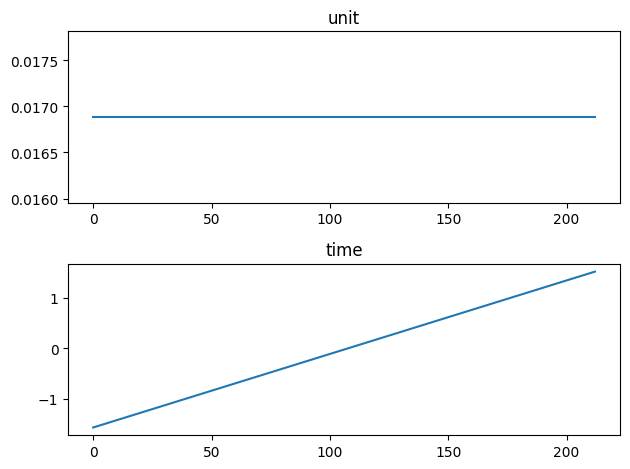

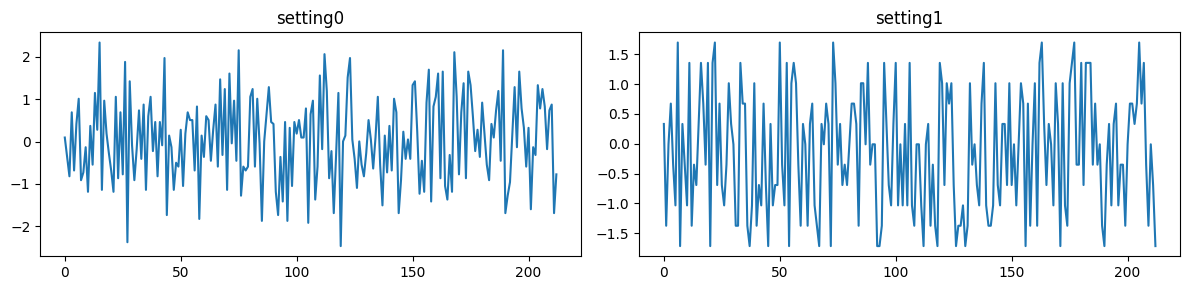

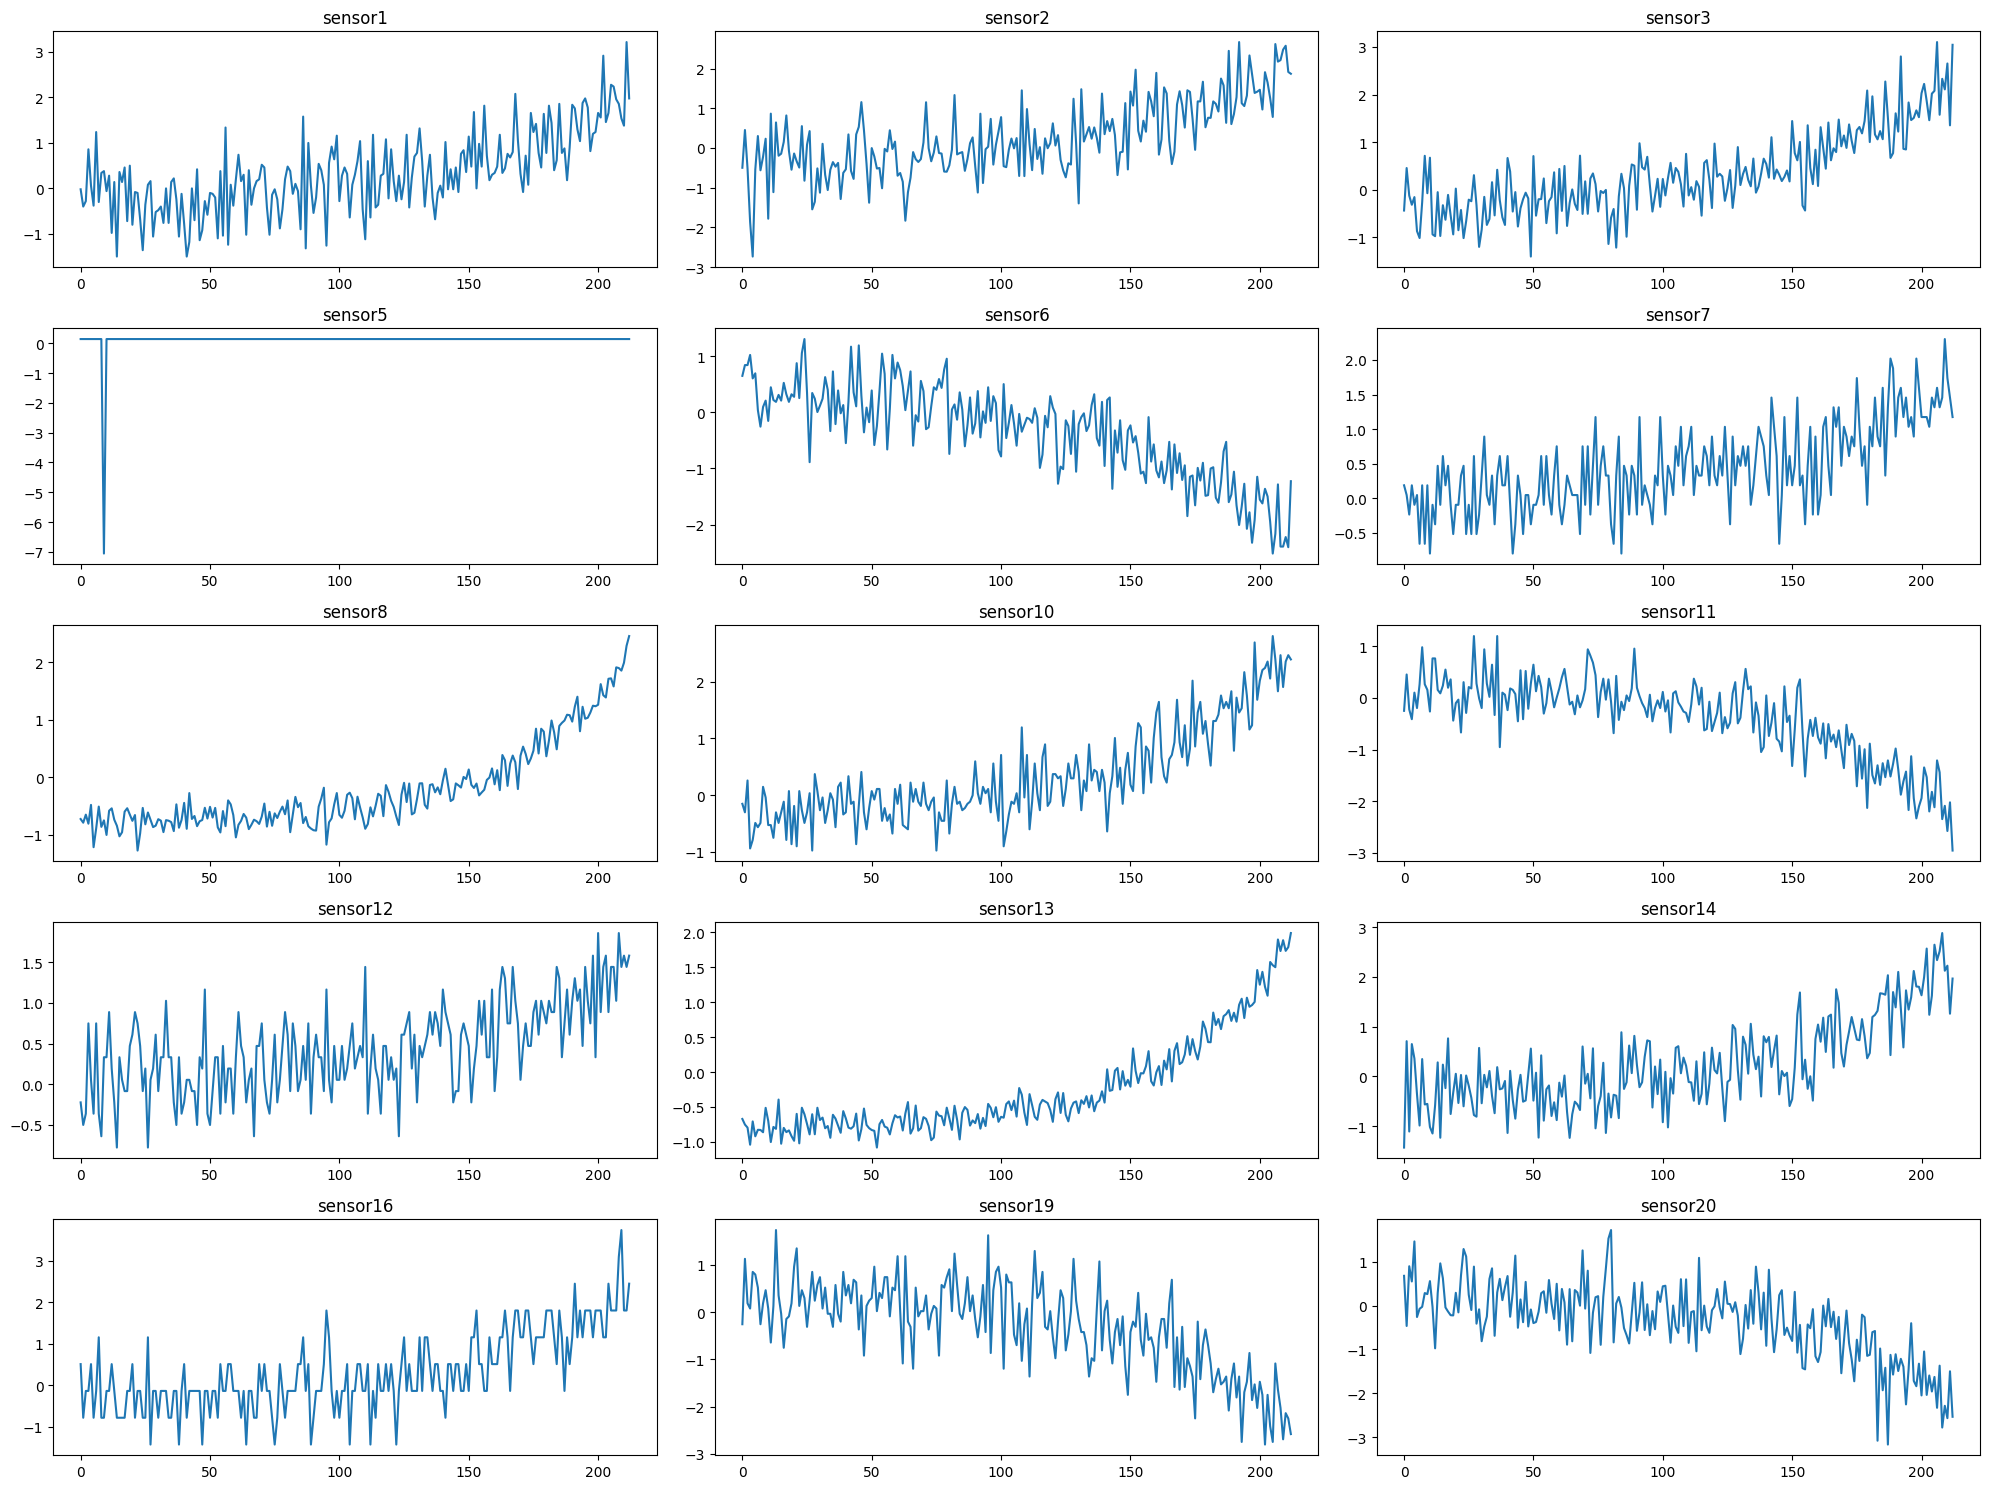

In [ ]:
#plot the normalized input data for a single unit
unit_data = data_train[data_train['unit'] == unit_num] # Pick a random unit
unit_data_scaled = scaler.transform(unit_data)

# Plot unit and time
fig, ax = plt.subplots(2, 1)
ax[0].plot(unit_data_scaled[:, 0])
ax[0].set_title('unit')
ax[1].plot(unit_data_scaled[:, 1])
ax[1].set_title('time')
fig.tight_layout()
plt.show()
plt.close()

fig, ax = plt.subplots(1, 2, figsize=(12, 3))
ax[0].plot(unit_data_scaled[:, 2])
ax[0].set_title('setting0')
ax[1].plot(unit_data_scaled[:, 3])
ax[1].set_title('setting1')
fig.tight_layout()
plt.show()
plt.close()

sensor_columns = data_train.keys()[4:]

fig, ax = plt.subplots(5, 3, figsize=(20, 15))
for i, sensor in enumerate(sensor_columns):
  ax[i//3, i%3].plot(unit_data_scaled[:, 4+i])
  ax[i//3, i%3].set_title(sensor)
fig.tight_layout()
plt.show()
plt.close()

The total dataset is now scaled so that every column has a mean, $\mu = 0$, and a standard deviation, $\sigma = 1$. When looking at the single unit data we can see that it is similar to before, only with a different scale.

Also all unnecessary columns have been deleted

## 8) Preparing the labels for the training data

In [ ]:
#calculate the RUL per time step (labels for training)
# you don't have to touch this

data_numpy = np.genfromtxt('train_FD001.txt')

engine_time = []

for i in range(len(data_numpy)):
  if data_numpy[i, 0] != data_numpy[i-1, 0]:
      time_steps_data = []
      engine_time.append(time_steps_data)
  time_steps_data.append(data_numpy[i, 1])

engine_RUL = []

for i in range(len(engine_time)):
  rul_new_data = np.array(engine_time[i])
  engine_RUL += list(np.flip(rul_new_data))

label_train = pd.DataFrame(engine_RUL)
label_train.columns = ['RUL']

print(label_train.shape)

(20631, 1)


## 9) Plot cycle time and RUL for all units

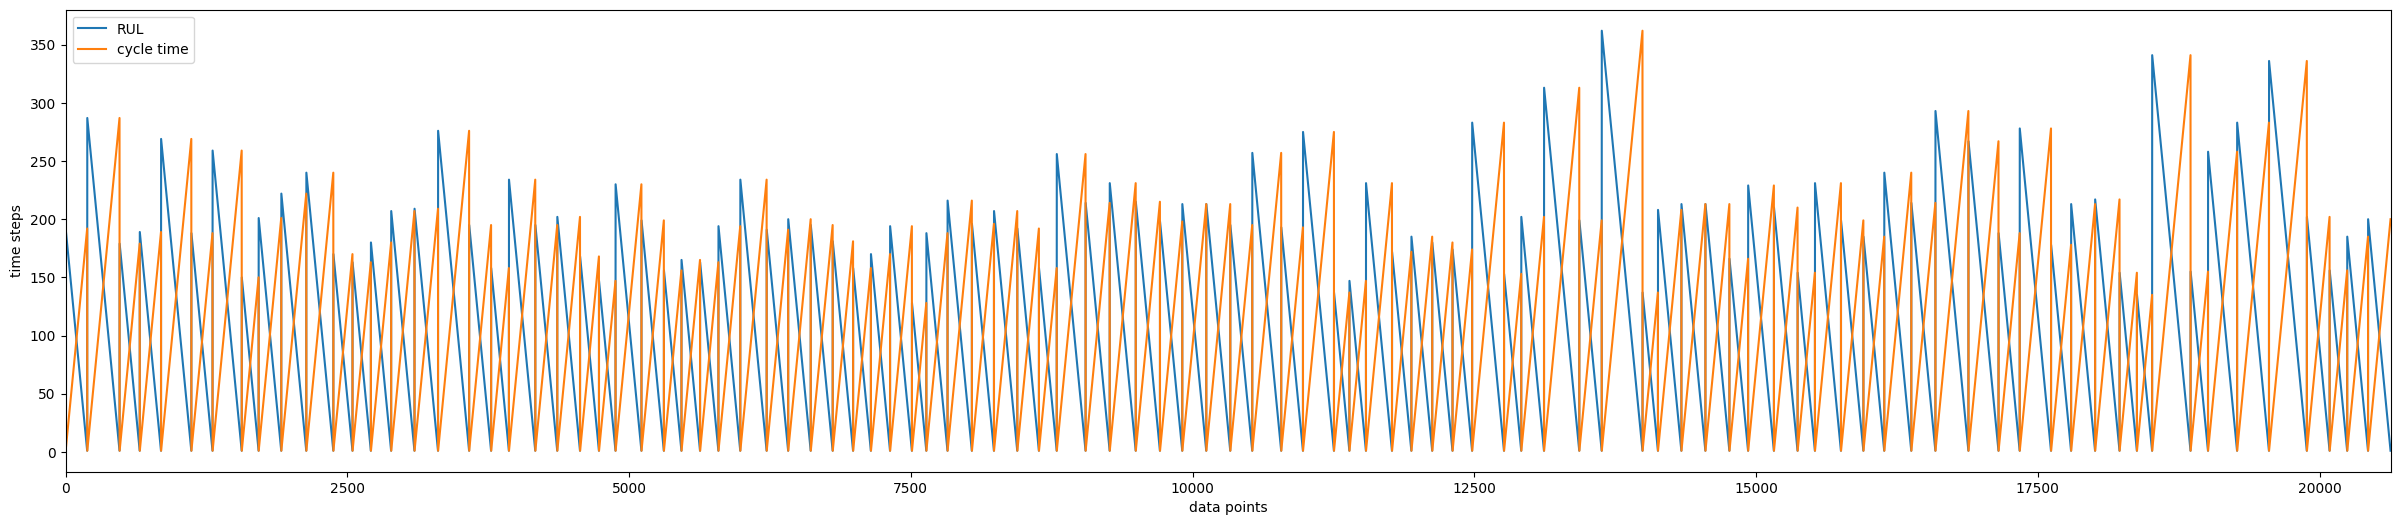

In [ ]:
#plot the labels of the training data set
plt.figure(figsize=(30,6))

plt.plot(label_train['RUL'], label='RUL')
plt.plot(data_train['time'], label='cycle time')
plt.xlim(0, len(data_train))
plt.xlabel('data points')
plt.ylabel('time steps')
plt.legend()
plt.show()

## 10) Creating time series samples

In [ ]:
#creating time series samples with length n_past to predict the RUL n_future steps in the future

trainX = []
trainY = []

n_future = 1
n_past = 30

for i in range(n_past, len(data_train_scaled) - n_future +1):
    trainX.append(data_train_scaled[i - n_past:i, 0:data_train_scaled.shape[1]])
    trainY.append(label_train[i + n_future - 1:i + n_future])

trainX_all, trainY_all = np.array(trainX), np.array(trainY)[:,0]

print('trainX shape == {}.'.format(trainX_all.shape))
print('trainY shape == {}.'.format(trainY_all.shape))

trainX shape == (20601, 30, 19).
trainY shape == (20601, 1).


This loop creates two lists for training where trainX is the input data trailing 30 data points back into the past. These points are used for predicting the next data point. The other list, trainY, is the corresponding output i.e. the following data point which is to be predicted.

I found that the optimal number of past data points, $n_{past}$, depends on the number of timesteps in a cycle, which in this case is $200$. $n_{past}$ should be copsen such that the total number of timesteps is not divisible by $n_{past}$:

\begin{equation}
  \# \textrm{timesteps} \nmid \# \textrm{data points}
\end{equation}

**Example**
For a cycle with 200 timesteps:

* $n_{past} = 40:$
\begin{equation}
  \frac{200}{40} = 5 \quad \textrm{not a good choice}
\end{equation}

* $n_{past} = 30:$
\begin{equation}
  \frac{200}{30} = 6.67 \quad \textrm{a better choice}
\end{equation}

I believe this is becausethe RUL is defined in cycles of timesteps. To accurately model this, we want the past data points to overlap with the cycle intersections. If $n_{past}$ divides the total timesteps evenly, there is a risk that key information at these intersections might be missed or poorly represented.

**Results:**
* $n_{past} = 40: MSE = 762.75$
* $n_{past} = 30: MSE = 549.59$


## 11) Preparing the test data

In [ ]:
#test data set without labels

data_test = pd.read_csv('test_FD001.txt', delimiter=' ', header=None)

name_list = ['unit', 'time', 'setting0', 'setting1', 'setting2']
for i in range(number_of_sensors):
  name_list.append('sensor'+str(i))
name_list.append('empty1')
name_list.append('empty2')
data_test.columns = name_list

data_test = data_test.drop(['empty1'], axis=1)
data_test = data_test.drop(['empty2'], axis=1)

#drop the unneccesary columns
data_test = data_test.drop(['setting2'], axis=1)
data_test = data_test.drop(['sensor0'], axis=1)
data_test = data_test.drop(['sensor4'], axis=1)
data_test = data_test.drop(['sensor9'], axis=1)
data_test = data_test.drop(['sensor15'], axis=1)
data_test = data_test.drop(['sensor17'], axis=1)
data_test = data_test.drop(['sensor18'], axis=1)

#normalization of the test data
data_test_scaled = scaler.transform(data_test)
print(f'data_test_scaled shape == {format(data_test_scaled.shape)}')

data_test_list = []
time_steps_data = np.empty((2, columns))

for i in range(len(data_test_scaled)):

  if i == len(data_test_scaled)-1:
    data_test_list.append(time_steps_data)

  elif data_test_scaled[i, 0] != data_test_scaled[i-1, 0]:
    time_steps_data = time_steps_data[1:]
    data_test_list.append(time_steps_data)
    time_steps_data = np.empty(columns)

  time_steps_data = np.vstack((time_steps_data, data_test_scaled[i]))
data_test_list = data_test_list[1:]

print('data_test_list length == {}.'.format(len(data_test_list)))
print('data_test_list first element shape == {}.'.format(data_test_list[0].shape))

data_test_scaled shape == (13096, 19)
data_test_list length == 100.
data_test_list first element shape == (31, 19).


## 12) Preparing the labels for the test data

In [ ]:
#test labels at the end of the series of each unit
# you don't have to touch this

label_test = pd.read_csv('RUL_FD001.txt', delimiter=' ', header=None)

name_list = ['RUL_final', 'empty']
label_test.columns = name_list
label_test = label_test.drop(['empty'], axis=1)

label_test_array = np.array(label_test)[:,0]

print('label_test shape == {}.'.format(label_test.shape))
print('label_test_array shape == {}.'.format(label_test_array.shape))

label_test shape == (100, 1).
label_test_array shape == (100,).


## 13) Define the RNN

In [ ]:
#Define the LSTM architecture

last_layer = 1

model = models.Sequential()
model.add(layers.LSTM(units=50, activation='relu', input_shape=(trainX_all.shape[1], trainX_all.shape[2])))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(units=50))  # Adjust units as needed
model.add(layers.Dropout(0.2))  # Adjust dropout rate as needed

model.add(layers.Dense(last_layer))

optimizer = keras.optimizers.Adam(learning_rate=0.01)

model.compile(optimizer=optimizer, loss='mse')
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_17 (LSTM)                       │ (None, 50)                  │          14,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 50)                  │           2,550 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,601 (64.85 KB)

 Trainable params: 16,601 (64.85 KB)

 Non-trainable params: 0 (0.00 B)

## 14) Train the RNN

In [ ]:
#Define callbacks to save the best model during the training

#Options for EarlyStopping, ReduceLROnPlateau and ModelCheckpoint
reduce_on_plateau = keras.callbacks.ReduceLROnPlateau(factor=0.67, patience=3, verbose=1, min_lr=1e-5),
early_stopping = keras.callbacks.EarlyStopping(patience=10, verbose=1)
model_checkpoint = keras.callbacks.ModelCheckpoint("best_model.keras", save_best_only=True, monitor='val_loss', mode='min')


results = model.fit(trainX_all, trainY_all,
    epochs=30,
    batch_size=32,
    verbose=1,
    validation_split=0.1,
    callbacks=[model_checkpoint, reduce_on_plateau, early_stopping])

Epoch 1/30
580/580 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - loss: 24380042.0000 - val_loss: 3712.9580 - learning_rate: 0.0100
Epoch 2/30
580/580 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - loss: 2477.3162 - val_loss: 3084.0542 - learning_rate: 0.0100
Epoch 3/30
580/580 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - loss: 2298.6853 - val_loss: 3061.0720 - learning_rate: 0.0100
Epoch 4/30
580/580 ━━━━━━━━━━━━━━━━━━━━ 22s 22ms/step - loss: 2238.5442 - val_loss: 2587.7280 - learning_rate: 0.0100
Epoch 5/30
580/580 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - loss: 2055.0474 - val_loss: 2730.7136 - learning_rate: 0.0100
Epoch 6/30
580/580 ━━━━━━━━━━━━━━━━━━━━ 19s 16ms/step - loss: 2107.8909 - val_loss: 2632.5337 - learning_rate: 0.0100
Epoch 7/30
579/580 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1980.8777
Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0066999998502433305.
580/580 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - loss: 1980.8683 - val_loss: 3174.1663 - learning_rate: 0.0100
Epoch 8/30
580/580 ━━━━━━━━━━━━━━━

## 15) Plot the results and Evaluate the performance

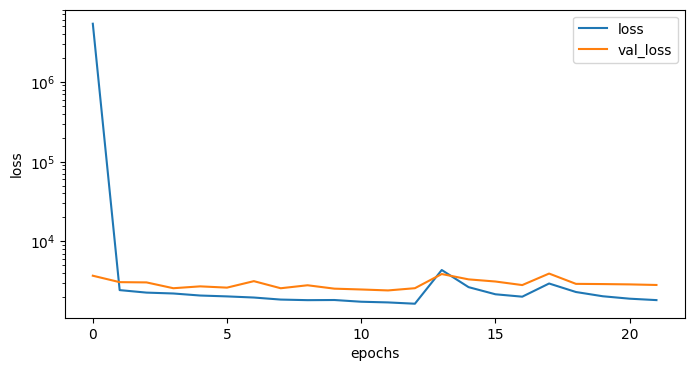

In [ ]:
#Plotting training loss and validation loss
plt.figure(figsize=(8,4))

plt.plot(results.history['loss'], label='loss')
plt.plot(results.history['val_loss'], label='val_loss')
plt.yscale('log')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

In [ ]:
#Testing on the training set to predict the RUL
model.load_weights("best_model.keras")
trainY_pred = model.predict(trainX_all)
print(trainY_pred.shape)

644/644 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step
(20601, 1)


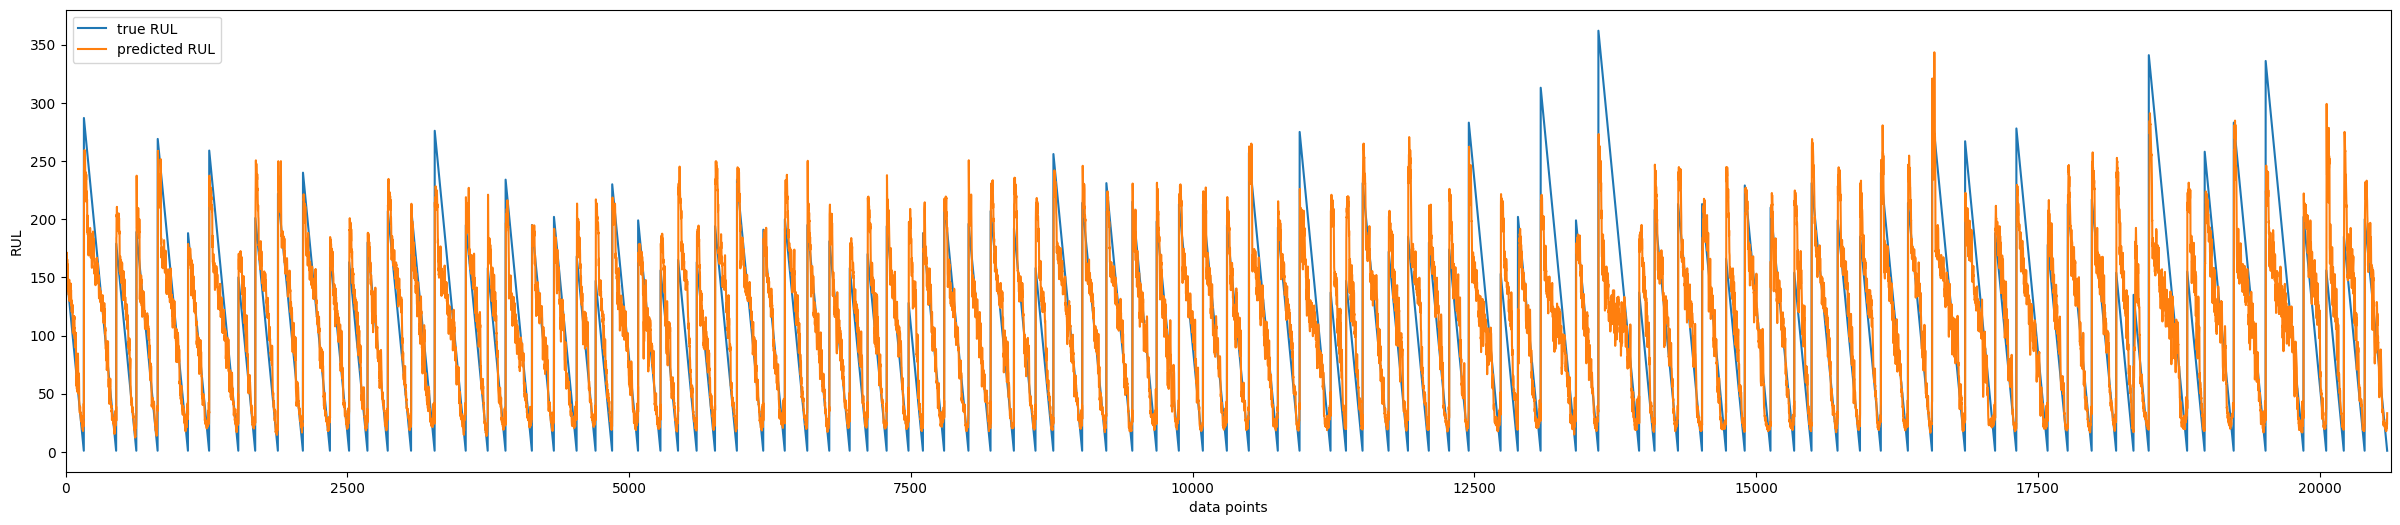

In [ ]:
#Plotting the true RUL and the network prediction for the training data set
plt.figure(figsize=(30,6))

plt.plot(trainY_all, label='true RUL')
plt.plot(trainY_pred, label='predicted RUL')
plt.xlim(0, len(data_train))
plt.xlabel('data points')
plt.ylabel('RUL')
plt.legend()
plt.show()

In [ ]:
#Testing on the n_past last samples of the test set to predict the RUL

test_data = []
predictions = []

model.load_weights("best_model.keras")

for i in range(len(data_test_list)):
  testing_set = np.expand_dims(data_test_list[i], axis=0)
  prediction = model.predict(testing_set[:, -n_past:])
  predictions.append(prediction[0][0])
  test_data.append(len(data_test_list[i]))

predictions = np.array(predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━

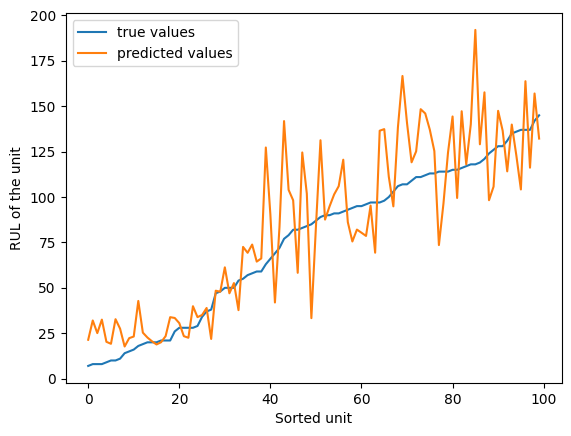

In [ ]:
#Plotting the prediction and the true values for each unit
#Hint: It's easier to compare the true values and the predicted values if you order them in a smart way.

idx_sort = np.argsort(label_test_array)
true_sort = label_test_array[idx_sort]
pred_sort = predictions[idx_sort]

plt.figure()

plt.plot(true_sort, label='true values')
plt.plot(pred_sort, label='predicted values')
plt.xlabel('Sorted unit')
plt.ylabel('RUL of the unit')
plt.legend()
plt.show()

In [ ]:
#calculate the MSE of the two arrays
mse = mean_squared_error(predictions, label_test_array)
print(f'MSE = {mse}')

MSE = 549.5959015948824


## 16) Recommend Maintenance

Standard deviation of the residuals = 21.904777459474033
Mean of the residuals = 8.353240451812745


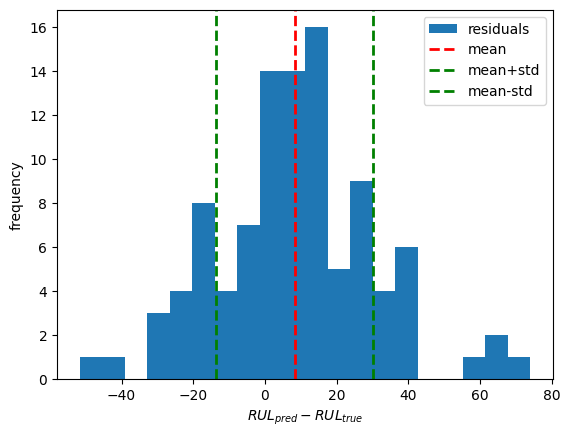

In [ ]:
#Plotting the residuals in a histogram and determine the standard diviation
std = np.std(np.array(predictions) - label_test_array)
mean = np.mean(np.array(predictions) - label_test_array)

print(f'Standard deviation of the residuals = {std}')
print(f'Mean of the residuals = {mean}')


plt.hist(np.array(predictions) - label_test_array, label='residuals', bins= 20)
plt.axvline(mean, color='red', linestyle='dashed', linewidth=2, label='mean')
plt.axvline(mean+std, color='green', linestyle='dashed', linewidth=2, label='mean+std')
plt.axvline(mean-std, color='green', linestyle='dashed', linewidth=2, label='mean-std')
plt.xlabel('$RUL_{pred} - RUL_{true}$')
plt.ylabel('frequency')
plt.legend()
plt.show()

In [ ]:
#answer to question 10:

output_for_maint = 20 + 2*std
print('The engine should be recomended for maintainance with an output below: ', output_for_maint)

The engine should be recomended for maintainance with an output below:  63.809554918948066
